In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.datasets import make_regression
import tensorflow as tf
from keras import backend as K
import itertools
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Layer, InputLayer, Reshape, Flatten, Conv1D, Conv2D, MaxPooling2D, AveragePooling2D
from keras.utils import plot_model, to_categorical
from custum_func import my_acc, my_loss, ExponentialLayer, ControlledDropoutLayer, dropout_conf_1, dropout_conf_2, dropout_conf_3, PowLayer, dropout_conf_4
import pickle
from keras.utils import CustomObjectScope

2023-05-16 17:49:34.502061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 17:49:34.673247: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-16 17:49:34.673271: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-16 17:49:35.467464: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Data

In [3]:
# load train_data

train_data = pd.read_csv(
    "../data_acquisition/data_0.3/training_standardized.csv", sep=";"
)

features = np.swapaxes(
    np.array(
        [
            train_data["home_xG"],
            train_data["home_xg_against"],
            train_data["away_xG"],
            train_data["away_xg_against"],
            train_data["home_xT_all"],
            train_data["home_xt_all_against"],
            train_data["away_xT_all"],
            train_data["away_xt_all_against"],
        ]
    ),
    0,
    1,
)

form = np.swapaxes(
    np.array(
        [
            (train_data["ha_form_home_for"]),
            (train_data["ha_form_home_against"]),
            (train_data["ha_form_away_for"]),
            (train_data["ha_form_away_against"]),
        ]
    ),
    0,
    1,
)

goals = np.swapaxes(
    np.array([train_data["home_score"], train_data["away_score"]]), 0, 1
)

elo_diff = np.swapaxes(
    np.array([(train_data["elo_diff_home"]), (train_data["elo_diff_away"])]), 0, 1
)

X = np.concatenate([features, form, elo_diff], axis=1)
y = np.array(goals, dtype=float)

In [4]:
test_data = pd.read_csv(
    "../data_acquisition/data_0.3/test_standardized.csv", sep=";"
).dropna()


features = np.swapaxes(
    np.array(
        [
            test_data["home_xG"],
            test_data["home_xg_against"],
            test_data["away_xG"],
            test_data["away_xg_against"],
            test_data["home_xT_all"],
            test_data["home_xt_all_against"],
            test_data["away_xT_all"],
            test_data["away_xt_all_against"],
        ]
    ),
    0,
    1,
)

form = np.swapaxes(
    np.array(
        [
            (test_data["ha_form_home_for"]),
            (test_data["ha_form_home_against"]),
            (test_data["ha_form_away_for"]),
            (test_data["ha_form_away_against"]),
        ]
    ),
    0,
    1,
)

goals = np.swapaxes(np.array([test_data["home_score"], test_data["away_score"]]), 0, 1)

elo = np.swapaxes(
    np.array([(test_data["elo_diff_home"]), (test_data["elo_diff_away"])]), 0, 1
)
X_test = np.concatenate([features, form, elo], axis=1)
y_test = np.array(goals, dtype=float)

In [5]:
X.resize((6082, 16))
X = X.reshape((6082, 4, 4))
X = X.reshape(list(X.shape) + [1])

test_shape = X_test.shape
X_test.resize((test_shape[0], 16))
X_test = X_test.reshape((test_shape[0], 4, 4))
X_test = X_test.reshape(list(X_test.shape) + [1])

# Create Model

In [6]:
TRAIN_MODEL = False

In [7]:
if TRAIN_MODEL:
    dconf1, dconf2 = dropout_conf_2(80, cnn=True)
    step_size = len(dconf1)
    model = Sequential()
    model.add(InputLayer(input_shape=(4, 4, 1)))
    model.add(ControlledDropoutLayer(dconf1))
    model.add(Conv2D(20, kernel_size=3, padding="valid"))
    model.add(Flatten())
    model.add(ControlledDropoutLayer(dconf2))
    model.add(Dense(2, activation="linear"))

    model.compile(loss=my_loss, optimizer='adam', metrics=my_acc)
    hist = model.fit(X, y, epochs=50, steps_per_epoch=step_size, shuffle=True)
    # if True:
    #     with CustomObjectScope({'ControlledDropoutLayer': ControlledDropoutLayer}):
    #         with open("models/cnn_dropout_2.pck", 'wb') as outp:
    #             pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)
# else:
#     with CustomObjectScope({'ControlledDropoutLayer': ControlledDropoutLayer}):
#         with open('models/cnn_dropout_2.pck', 'rb') as f:
#             model = pickle.load(f)
#             step_size = len(dropout_conf_2(80)[0])

# create predictions

In [8]:
if TRAIN_MODEL:
    preds = []
    for x in range(step_size):
        preds.append(model(X_test))
    preds = np.stack(preds)
    predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
    predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]
    if False:
        with open("models/cnn_dropout_2_PREDICTIONS.pck", 'wb') as outp:
            pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)

In [11]:
LOAD_PREDICTIONS = not TRAIN_MODEL


if LOAD_PREDICTIONS:
    with open('models/cnn_dropout_2_PREDICTIONS.pck', 'rb') as f:
        preds = pickle.load(f)
        predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
        predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]
        step_size = len(dropout_conf_2(80)[0])

In [12]:
home_std = np.std(predictions_home, axis=1)
away_std = np.std(predictions_away, axis=1)
print(f"Home std: {home_std.mean()}, Away std: {away_std.mean()}, Overall std: {(home_std.mean() + away_std.mean()) / 2}")
# Draw std Boxplots
if False:
    fig, (ax1, ax2) = plt.subplots(2, 2)
    fig.set_size_inches(10, 10)
    ax1[0].scatter(home_std, np.arange(1545))
    ax2[0].scatter(away_std, np.arange(1545))
    ax1[1].boxplot(home_std)
    ax2[1].boxplot(away_std)

Home std: 1.3687570095062256, Away std: 1.163231372833252, Overall std: 1.2659941911697388


In [13]:
act_res = []
for h, a in y_test:
    act_res.append(f"{str(int(h))}:{str(int(a))}")

predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]

game_quotes = []
most_goals = {"home": [], "away": []}
for game_idx in range(len(predictions_home)):
    game_df = pd.DataFrame(
        {"home": predictions_home[game_idx], "away": predictions_away[game_idx]}
    )
    game_df["diff"] = game_df["home"] - game_df["away"]
    game_df["clipped_res"] = np.clip(game_df["diff"], -1, 1)
    game_df["rounded_res"] = np.rint(game_df["clipped_res"])
    home = game_df.loc[game_df["rounded_res"] == 1].shape[0] / step_size
    draw = (
        game_df.loc[game_df["rounded_res"] == 0].shape[0] / step_size
    )
    away = game_df.loc[game_df["rounded_res"] == -1].shape[0] / step_size

    game_quotes.append(f"{round(home, 3)}-{round(draw, 3)}-{round(away, 3)}")

df_res = pd.DataFrame(
    {"actual": act_res, "predicted": game_quotes}
)
df_cross = pd.DataFrame(
    {
        "actual": [
            0
            if int(df_res.iloc[i]["actual"].split(":")[0])
            > int(df_res.iloc[i]["actual"].split(":")[1])
            else 1
            if int(df_res.iloc[i]["actual"].split(":")[0])
            == int(df_res.iloc[i]["actual"].split(":")[1])
            else 2
            for i in range(df_res.shape[0])
        ],
        "pred": [
            np.argmax([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
            for i in range(df_res.shape[0])
        ],
        "pred_val": [
            np.max([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
            for i in range(df_res.shape[0])
        ],
        "bookie": [
            np.argmax(
                [
                    test_data.iloc[i].bookie_home,
                    test_data.iloc[i].bookie_draw,
                    test_data.iloc[i].bookie_away,
                ]
            )
            for i in range(test_data.shape[0])
        ],
        "bookie_val": [
            np.max(
                [
                    test_data.iloc[i].bookie_home,
                    test_data.iloc[i].bookie_draw,
                    test_data.iloc[i].bookie_away,
                ]
            )
            for i in range(test_data.shape[0])
        ],
    }
)

In [14]:
print("Verteilung:")
print(
    f"Anzahl Predicted Home: {df_cross[df_cross['pred'] == 0].shape[0]} ({round(df_cross[df_cross['pred'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Home: {round(df_cross[df_cross['actual'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Draw: {df_cross[df_cross['pred'] == 1].shape[0]} ({round(df_cross[df_cross['pred'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Draw: {round(df_cross[df_cross['actual'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Away: {df_cross[df_cross['pred'] == 2].shape[0]} ({round(df_cross[df_cross['pred'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Away: {round(df_cross[df_cross['actual'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    "---------------------------------------------------------------------------------"
)
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_cross.shape[0]):
    if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
        if df_cross.iloc[x]["pred"] == 0:
            if df_cross.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_cross.iloc[x]["pred"] == 1:
            if df_cross.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_cross.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_cross.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_cross.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1

home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_cross.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_cross.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_cross[df_cross['actual'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(f"Home Pred. aber Draw --> {home_pred['act_draw']}")
print(f"Home Pred. aber Away --> {home_pred['act_away']}")
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_cross[df_cross['actual'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(f"Draw Pred. aber Home --> {draw_pred['act_home']}")
print(f"Draw Pred. aber Away --> {draw_pred['act_away']}")
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_cross[df_cross['actual'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)
print(f"Away Pred. aber Home --> {away_pred['act_home']}")
print(f"Away Pred. aber Draw --> {away_pred['act_draw']}")

Verteilung:
Anzahl Predicted Home: 721 (46.67%) | Verteilung Tatsächlich Home: 42.78%
Anzahl Predicted Draw: 350 (22.65%) | Verteilung Tatsächlich Draw: 25.5%
Anzahl Predicted Away: 474 (30.68%) | Verteilung Tatsächlich Away: 31.72%
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Prediction:
Anzahl Korrekt: 830 (53.72%), Anzahl Falsch: 715 (46.28%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 455 (68.84%), Anzahl Home Falsch: 266
Home Pred. aber Draw --> 156
Home Pred. aber Away --> 110
Anzahl Draw Korrekt: 108 (27.41%), Anzahl Draw Falsch: 242
Draw Pred. aber Home --> 129
Draw Pred. aber Away --> 113
Anzahl Away Korrekt: 267 (54.49%), Anzahl Away Falsch: 207
Away Pred. aber Home --> 77
Away Pred. aber Draw --> 130


# Average predictions

In [15]:
h = np.array([np.array(xi, dtype=float) for xi in df_res.predicted.str.split("-")])[:,0]
d = np.array([np.array(xi, dtype=float) for xi in df_res.predicted.str.split("-")])[:,1]
a = np.array([np.array(xi, dtype=float) for xi in df_res.predicted.str.split("-")])[:,2]

print(np.mean(h))
print(np.mean(d))
print(np.mean(a))

0.41115016181229774
0.2672258899676376
0.32161877022653723


# Histograms

Observed: Home: 1.5348569549490299, away: 1.2387372574810918
Predicted: Home:1.2047448440586102, Away: 0.9720558882235529


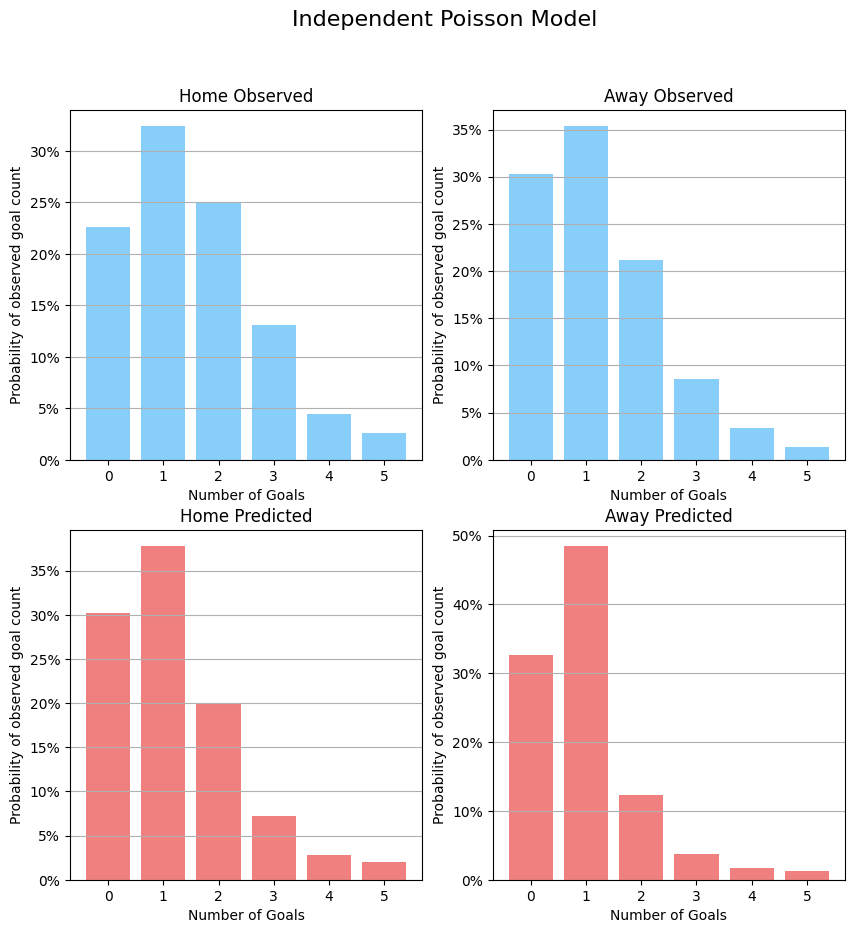

In [16]:
home_histograms, away_histograms = [], []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        np.array(predictions_home[game_idx], dtype=int), [0, 1, 2, 3, 4, 5, 6]
    )
    away_hist, bin_edges = np.histogram(
        np.array(predictions_away[game_idx], dtype=int), [0, 1, 2, 3, 4, 5, 6]
    )
    home_histograms.append(home_hist)
    away_histograms.append(away_hist)

home_cum_hist = np.sum(home_histograms, axis=0)
away_cum_hist = np.sum(away_histograms, axis=0)

if True: # draw histograms
    his_h, _ = np.histogram(train_data.home_score, [0, 1, 2, 3, 4, 5, 6])
    his_a, _ = np.histogram(train_data.away_score, [0, 1, 2, 3, 4, 5, 6])
    fig, (ax1, ax2) = plt.subplots(2, 2)
    fig.set_size_inches(10, 10)
    fig.suptitle("Independent Poisson Model", fontsize=16)
    ax1[0].bar(np.arange(len(his_h)), his_h / np.sum(his_h), color="lightskyblue")
    ax1[0].set_title("Home Observed")
    ax1[0].set_xlabel("Number of Goals")
    ax1[0].set_ylabel("Probability of observed goal count")
    ax1[0].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
    )
    ax1[0].grid(axis="y")

    ax2[0].bar(
        np.arange(len(home_cum_hist)),
        home_cum_hist / np.sum(home_cum_hist),
        color="lightcoral",
    )
    ax2[0].set_title("Home Predicted")
    ax2[0].set_xlabel("Number of Goals")
    ax2[0].set_ylabel("Probability of observed goal count")
    ax2[0].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
    )
    ax2[0].grid(axis="y")

    ax1[1].bar(np.arange(len(his_a)), his_a / np.sum(his_a), color="lightskyblue")
    ax1[1].set_title("Away Observed")
    ax1[1].set_xlabel("Number of Goals")
    ax1[1].set_ylabel("Probability of observed goal count")
    ax1[1].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
    )
    ax1[1].grid(axis="y")

    ax2[1].bar(
        np.arange(len(away_cum_hist)),
        away_cum_hist / np.sum(away_cum_hist),
        color="lightcoral",
    )
    ax2[1].set_title("Away Predicted")
    ax2[1].set_xlabel("Number of Goals")
    ax2[1].set_ylabel("Probability of observed goal count")
    ax2[1].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
    )
    ax2[1].grid(axis="y")

print(f"Observed: Home: {np.mean(train_data.home_score)}, away: {np.mean(train_data.away_score)}")
print(f"Predicted: Home:{np.sum([x * idx for idx, x in enumerate(home_cum_hist)]) / np.sum(home_cum_hist)}, Away: {np.sum([x * idx for idx, x in enumerate(away_cum_hist)]) / np.sum(away_cum_hist)}")

Observed: Over: 0.4278317152103559, Diagonal: 0.25501618122977343, Under: 0.31715210355987045
Predicted: Over: 0.41089702516197607, Diagonal: 0.3006155362111302, Under: 0.28848743862689535


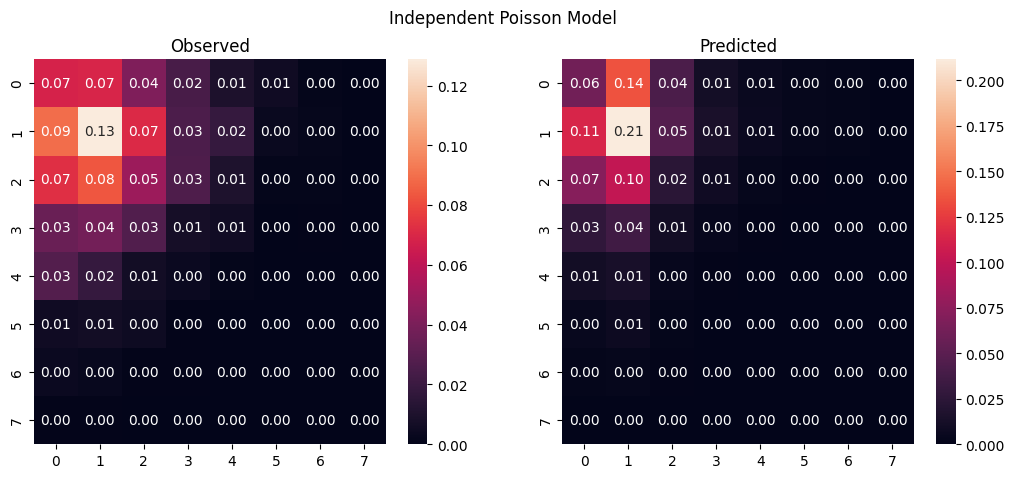

In [17]:
if True:
    # actual
    max_goals = int(np.max(y_test)) + 1
    res_table_a = np.array([np.zeros(max_goals) for _ in range(max_goals)])
    for h, a in y_test:
        res_table_a[int(h)][int(a)] += 1
    res_table_a = res_table_a / test_data.shape[0]

    # predicted
    max_goals = int(np.max(y_test)) + 1
    res_table_p = np.array([np.zeros(max_goals) for _ in range(max_goals)])

    game_quotes = []
    for game_idx in range(len(predictions_home)):
        home_hist, bin_edges = np.histogram(
            predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
        )
        away_hist, bin_edges = np.histogram(
            predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
        )
        if home_hist.shape[0] < max_goals:
            home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
        if away_hist.shape[0] < max_goals:
            away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

        home_hist = home_hist / sum(home_hist) # step_size
        away_hist = away_hist / sum(away_hist) # step_size
        probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
        probs = probs
        res_table_p += probs

    res_table_p = res_table_p / test_data.shape[0]

    # sb.heatmap(res_table_p, annot=True)

    # top pred result:
    max_goals = int(np.max(y_test)) + 1
    res_table_pr = np.array([np.zeros(max_goals) for _ in range(max_goals)])

    game_quotes = []
    for game_idx in range(len(predictions_home)):
        home_hist, bin_edges = np.histogram(
            predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
        )
        away_hist, bin_edges = np.histogram(
            predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
        )
        res_table_pr[np.argmax(home_hist)][np.argmax(away_hist)] += 1
    res_table_pr = res_table_pr / test_data.shape[0]
    # sb.heatmap(res_table_pr, annot=True)

    fig, axes = plt.subplots(1, 2, figsize=(12.5, 5))
    fig.suptitle("Independent Poisson Model")
    sb.heatmap(ax=axes[0], data=res_table_a, annot=True, fmt=".2f")
    axes[0].set_title("Observed")
    sb.heatmap(ax=axes[1], data=res_table_p, annot=True, fmt=".2f")
    axes[1].set_title("Predicted")

    print(f"Observed: Over: {np.tril(res_table_a).sum() - np.trace(res_table_a)}, Diagonal: {np.trace(res_table_a)}, Under: {np.triu(res_table_a).sum() - np.trace(res_table_a)}")
    print(f"Predicted: Over: {np.tril(res_table_p).sum() - np.trace(res_table_p)}, Diagonal: {np.trace(res_table_p)}, Under: {np.triu(res_table_p).sum() - np.trace(res_table_p)}")


In [18]:
# ece
data_length = df_cross.shape[0]
acc_home = (
    df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
print(f"Predicted ECE Home: {abs(acc_home - conf_home)}")
print(f"Predicted ECE Draw: {abs(acc_draw - conf_draw)}")
print(f"Predicted ECE Away: {abs(acc_away - conf_away)}")

Predicted ECE Home: 0.02404723855965718
Predicted ECE Draw: 0.23048261058738223
Predicted ECE Away: 0.10024550073193839


# Betting

In [19]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1004
# won: 467
# lost: 537
# money:  6749.102471962487

bets: 1304
won: 600
lost: 704
money:  4223.3


# Controlled Dropout Pipeline

In [20]:
if False: # run cell or not
    run_size = 1
    run_params = []
    # run_params.append(dropout_conf_1(cnn=True))
    run_params.append(dropout_conf_2(80, cnn=True))
    # run_params.append(dropout_conf_3(cnn=True))
    # dconf1, dconf2 = dropout_conf_1(cnn=True)
    # tmp1, tmp2 = dropout_conf_2(cnn=True)
    # dconf1 = np.concatenate([dconf1, tmp1])
    # dconf2 = np.concatenate([dconf2, tmp2])
    # run_params.append((dconf1, dconf2))
    # dconf1, dconf2 = dropout_conf_1(cnn=True)
    # tmp1, tmp2 = dropout_conf_3(cnn=True)
    # dconf1 = np.concatenate([dconf1, tmp1])
    # dconf2 = np.concatenate([dconf2, tmp2])
    # run_params.append((dconf1, dconf2))
    # dconf1, dconf2 = dropout_conf_2(cnn=True)
    # tmp1, tmp2 = dropout_conf_3(cnn=True)
    # dconf1 = np.concatenate([dconf1, tmp1])
    # dconf2 = np.concatenate([dconf2, tmp2])
    # run_params.append((dconf1, dconf2))
    # dconf1, dconf2 = dropout_conf_1(cnn=True)
    # tmp1, tmp2 = dropout_conf_2(cnn=True)
    # tmp3, tmp4 = dropout_conf_3(cnn=True)
    # dconf1 = np.concatenate([dconf1, tmp1, tmp3])
    # dconf2 = np.concatenate([dconf2, tmp2, tmp4])
    # run_params.append((dconf1, dconf2))

    dropout_version_df, test_acc_df, std_df, ece_h_df, ece_d_df, ece_a_df = [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)]

    for i in range(run_size):
        for d_idx, (dconf1, dconf2) in enumerate(run_params):
            step_size = len(dconf1)
            dropout_version_df[i].append(d_idx)
            model = Sequential()
            model.add(InputLayer(input_shape=(4, 4, 1)))
            model.add(ControlledDropoutLayer(dconf1))
            model.add(Conv2D(20, kernel_size=3, padding="valid"))
            model.add(Flatten())
            model.add(ControlledDropoutLayer(dconf2))
            model.add(Dense(2, activation="linear"))

            model.compile(loss=my_loss, optimizer='adam', metrics=my_acc)
            hist = model.fit(X, y, epochs=50, steps_per_epoch=step_size, shuffle=True)

            preds = []
            for x in range(step_size):
                preds.append(model(X_test))

            preds = np.stack(preds)
            predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
            predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]
            home_std = np.std(predictions_home, axis=1)
            away_std = np.std(predictions_away, axis=1)

            std_df[i].append(((home_std.mean() + away_std.mean()) / 2))

            act_res = []
            for h, a in y_test:
                act_res.append(f"{str(int(h))}:{str(int(a))}")

            predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
            predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]

            game_quotes = []
            most_goals = {"home": [], "away": []}
            for game_idx in range(len(predictions_home)):
                game_df = pd.DataFrame(
                    {"home": predictions_home[game_idx], "away": predictions_away[game_idx]}
                )
                game_df["diff"] = game_df["home"] - game_df["away"]
                game_df["clipped_res"] = np.clip(game_df["diff"], -1, 1)
                game_df["rounded_res"] = np.rint(game_df["clipped_res"])
                home = game_df.loc[game_df["rounded_res"] == 1].shape[0] / step_size
                draw = (
                    game_df.loc[game_df["rounded_res"] == 0].shape[0] / step_size
                )
                away = game_df.loc[game_df["rounded_res"] == -1].shape[0] / step_size

                game_quotes.append(f"{round(home, 3)}-{round(draw, 3)}-{round(away, 3)}")

            df_res = pd.DataFrame(
                {"actual": act_res, "predicted": game_quotes}
            ) 
            df_cross = pd.DataFrame(
                {
                    "actual": [
                        0
                        if int(df_res.iloc[i]["actual"].split(":")[0])
                        > int(df_res.iloc[i]["actual"].split(":")[1])
                        else 1
                        if int(df_res.iloc[i]["actual"].split(":")[0])
                        == int(df_res.iloc[i]["actual"].split(":")[1])
                        else 2
                        for i in range(df_res.shape[0])
                    ],
                    "pred": [
                        np.argmax([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
                        for i in range(df_res.shape[0])
                    ],
                    "pred_val": [
                        np.max([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
                        for i in range(df_res.shape[0])
                    ],
                    "bookie": [
                        np.argmax(
                            [
                                test_data.iloc[i].bookie_home,
                                test_data.iloc[i].bookie_draw,
                                test_data.iloc[i].bookie_away,
                            ]
                        )
                        for i in range(test_data.shape[0])
                    ],
                    "bookie_val": [
                        np.max(
                            [
                                test_data.iloc[i].bookie_home,
                                test_data.iloc[i].bookie_draw,
                                test_data.iloc[i].bookie_away,
                            ]
                        )
                        for i in range(test_data.shape[0])
                    ],
                }
            )
            right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
            home_pred = {"act_away": 0, "act_draw": 0}
            draw_pred = {"act_away": 0, "act_home": 0}
            away_pred = {"act_home": 0, "act_draw": 0}
            for x in range(df_cross.shape[0]):
                if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
                    if df_cross.iloc[x]["pred"] == 0:
                        if df_cross.iloc[x]["actual"] == 1:
                            home_pred["act_draw"] += 1
                        else:
                            home_pred["act_away"] += 1
                    elif df_cross.iloc[x]["pred"] == 1:
                        if df_cross.iloc[x]["actual"] == 0:
                            draw_pred["act_home"] += 1
                        else:
                            draw_pred["act_away"] += 1
                    else:
                        if df_cross.iloc[x]["actual"] == 0:
                            away_pred["act_home"] += 1
                        else:
                            away_pred["act_draw"] += 1
                    wrong += 1
                else:
                    if df_cross.iloc[x]["actual"] == 0:
                        home_right += 1
                    elif df_cross.iloc[x]["actual"] == 1:
                        draw_right += 1
                    else:
                        away_right += 1
                    right += 1

            home_wrong = home_pred["act_away"] + home_pred["act_draw"]
            draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
            away_wrong = away_pred["act_home"] + away_pred["act_draw"]
            acc = right / df_cross.shape[0]
            test_acc_df[i].append(acc)
            
            # ece
            data_length = df_cross.shape[0]
            acc_home = (
                df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
            ) / df_cross.loc[df_cross["actual"] == 0].shape[0]
            acc_draw = (
                df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
            ) / df_cross.loc[df_cross["actual"] == 1].shape[0]
            acc_away = (
                df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
            ) / df_cross.loc[df_cross["actual"] == 2].shape[0]

            conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
            conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
            conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
            ece_h_df[i].append(abs(acc_home - conf_home))
            ece_d_df[i].append(abs(acc_draw - conf_draw))
            ece_a_df[i].append(abs(acc_away - conf_away))

    auswertung = pd.DataFrame({"dropout_conf": np.mean(dropout_version_df, axis=0), "test_acc": np.mean(test_acc_df, axis=0), "std": np.mean(std_df, axis=0), "ece_h": np.mean(ece_h_df, axis=0), "ece_d": np.mean(ece_d_df, axis=0), "ece_a": np.mean(ece_a_df, axis=0)})
    auswertung.head(10)

# ece analyse pipeline 

In [21]:
if False: # run cell or not
    run_size = 5
    link_version_version_df, test_acc_df, std_df, ece_h_df, ece_d_df, ece_a_df = [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)]

    for i in range(run_size):
        for lf in range(2):
            dconf1, dconf2 = dropout_conf_2(80, cnn=True)
            step_size = len(dconf1)
            link_version_version_df[i].append(lf)
            model = Sequential()
            model.add(InputLayer(input_shape=(4, 4, 1)))
            model.add(ControlledDropoutLayer(dconf1))
            model.add(Conv2D(20, kernel_size=3, padding="valid"))
            model.add(Flatten())
            model.add(ControlledDropoutLayer(dconf2))
            model.add(Dense(2, activation="linear"))
            if lf == 0:
                model.add(ExponentialLayer(2))
            else:
                model.add(PowLayer(2,2))

            model.compile(loss=my_loss, optimizer='adam', metrics=my_acc)
            hist = model.fit(X, y, epochs=50, steps_per_epoch=step_size, shuffle=True)

            preds = []
            for x in range(step_size):
                preds.append(model(X_test))

            preds = np.stack(preds)
            predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
            predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]
            home_std = np.std(predictions_home, axis=1)
            away_std = np.std(predictions_away, axis=1)

            std_df[i].append(((home_std.mean() + away_std.mean()) / 2))

            act_res = []
            for h, a in y_test:
                act_res.append(f"{str(int(h))}:{str(int(a))}")

            predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
            predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]

            game_quotes = []
            most_goals = {"home": [], "away": []}
            for game_idx in range(len(predictions_home)):
                game_df = pd.DataFrame(
                    {"home": predictions_home[game_idx], "away": predictions_away[game_idx]}
                )
                game_df["diff"] = game_df["home"] - game_df["away"]
                game_df["clipped_res"] = np.clip(game_df["diff"], -1, 1)
                game_df["rounded_res"] = np.rint(game_df["clipped_res"])
                home = game_df.loc[game_df["rounded_res"] == 1].shape[0] / step_size
                draw = (
                    game_df.loc[game_df["rounded_res"] == 0].shape[0] / step_size
                )
                away = game_df.loc[game_df["rounded_res"] == -1].shape[0] / step_size

                game_quotes.append(f"{round(home, 3)}-{round(draw, 3)}-{round(away, 3)}")

            df_res = pd.DataFrame(
                {"actual": act_res, "predicted": game_quotes}
            ) 
            df_cross = pd.DataFrame(
                {
                    "actual": [
                        0
                        if int(df_res.iloc[i]["actual"].split(":")[0])
                        > int(df_res.iloc[i]["actual"].split(":")[1])
                        else 1
                        if int(df_res.iloc[i]["actual"].split(":")[0])
                        == int(df_res.iloc[i]["actual"].split(":")[1])
                        else 2
                        for i in range(df_res.shape[0])
                    ],
                    "pred": [
                        np.argmax([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
                        for i in range(df_res.shape[0])
                    ],
                    "pred_val": [
                        np.max([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
                        for i in range(df_res.shape[0])
                    ],
                    "bookie": [
                        np.argmax(
                            [
                                test_data.iloc[i].bookie_home,
                                test_data.iloc[i].bookie_draw,
                                test_data.iloc[i].bookie_away,
                            ]
                        )
                        for i in range(test_data.shape[0])
                    ],
                    "bookie_val": [
                        np.max(
                            [
                                test_data.iloc[i].bookie_home,
                                test_data.iloc[i].bookie_draw,
                                test_data.iloc[i].bookie_away,
                            ]
                        )
                        for i in range(test_data.shape[0])
                    ],
                }
            )
            right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
            home_pred = {"act_away": 0, "act_draw": 0}
            draw_pred = {"act_away": 0, "act_home": 0}
            away_pred = {"act_home": 0, "act_draw": 0}
            for x in range(df_cross.shape[0]):
                if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
                    if df_cross.iloc[x]["pred"] == 0:
                        if df_cross.iloc[x]["actual"] == 1:
                            home_pred["act_draw"] += 1
                        else:
                            home_pred["act_away"] += 1
                    elif df_cross.iloc[x]["pred"] == 1:
                        if df_cross.iloc[x]["actual"] == 0:
                            draw_pred["act_home"] += 1
                        else:
                            draw_pred["act_away"] += 1
                    else:
                        if df_cross.iloc[x]["actual"] == 0:
                            away_pred["act_home"] += 1
                        else:
                            away_pred["act_draw"] += 1
                    wrong += 1
                else:
                    if df_cross.iloc[x]["actual"] == 0:
                        home_right += 1
                    elif df_cross.iloc[x]["actual"] == 1:
                        draw_right += 1
                    else:
                        away_right += 1
                    right += 1

            home_wrong = home_pred["act_away"] + home_pred["act_draw"]
            draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
            away_wrong = away_pred["act_home"] + away_pred["act_draw"]
            acc = right / df_cross.shape[0]
            test_acc_df[i].append(acc)
            
            # ece
            data_length = df_cross.shape[0]
            acc_home = (
                df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
            ) / df_cross.loc[df_cross["actual"] == 0].shape[0]
            acc_draw = (
                df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
            ) / df_cross.loc[df_cross["actual"] == 1].shape[0]
            acc_away = (
                df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
            ) / df_cross.loc[df_cross["actual"] == 2].shape[0]

            conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
            conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
            conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
            ece_h_df[i].append(abs(acc_home - conf_home))
            ece_d_df[i].append(abs(acc_draw - conf_draw))
            ece_a_df[i].append(abs(acc_away - conf_away))

    auswertung = pd.DataFrame({"link_version": np.mean(link_version_version_df, axis=0), "test_acc": np.mean(test_acc_df, axis=0), "std": np.mean(std_df, axis=0), "ece_h": np.mean(ece_h_df, axis=0), "ece_d": np.mean(ece_d_df, axis=0), "ece_a": np.mean(ece_a_df, axis=0)})
    auswertung.head(10)